In [1]:
# File System
import os, sys, pickle as pkl
from os import path as pth
import itertools as it

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from corner import corner

# Math
import numpy as np
from numpy import linalg as la
import pandas as pd
pd.options.mode.chained_assignment = None

from scipy.stats import norm, uniform, multivariate_normal
import scipy.optimize as opt
from functools import reduce, partial

# Display
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import logging as lg
lg.basicConfig(level=lg.WARNING)

from Model import TwoSignal, Signal
from mcmc import MHMCMC

data_path = "data"

In [2]:
np.random.seed(123)

In [3]:
class LnMinMCMC(MHMCMC):
    def selection(self):
        qs = self.proposal()
        r = uniform.rvs(0,1)
                   
        if (self.f(self.x) - self.f(np.array(qs)) > np.log(r)):
            self.x = qs

        return self.x 

In [4]:
def conf(s, interval=0.95):
    sord = np.sort(s)
    lo, hi = np.floor(s.size*(1-interval)/2), s.size - np.ceil(s.size*(1-interval)/2)
    return np.array([sord[int(lo)], sord[int(hi)]])

### Problem 1

In [5]:
with open(pth.join(data_path, 'dataset11.pkl'), 'rb') as f:
    d11 = pkl.load(f)

In [6]:
sig2 = TwoSignal(100, 257.5, np.zeros(5), d11)
sig2.set_params(sig2.analytic_params()[0])
_=opt.minimize(lambda p: TwoSignal.with_period_param(100, p, d11).negloglike()
             , np.array([sig2.T2, *sig2.params]))

In [7]:
amps = sig2.amplitude
amp_errs = sig2.analytic_amplitude_error

In [8]:
def param_prior(p):
    T = period_prior(p[0])
    dc = dc_prior(p[1])
    amp1 = amp1_prior(p[2:4])
    amp2 = amp2_prior(p[4:6])
    
    return -np.sum(np.log([T, dc, amp1, amp2]))

period_prior = lambda p: norm(sig2.T2, 0.21).pdf(p)
dc_prior = lambda p: norm(sig2.DC ,0.5).pdf(p)
amp1_prior = lambda p: norm(loc = amps[0], scale=2*amp_errs[0]).pdf(np.sqrt(np.sum(np.power(p, 2))))
amp2_prior = lambda p: norm(loc = amps[1], scale=2*amp_errs[1]).pdf(np.sqrt(np.sum(np.power(p, 2))))

In [9]:
prbm1_q = lambda p: norm.rvs(loc=p, scale=np.array([1e-3, 1e-1, 1e-2, 1e-2, 1e-3, 1e-2]))
prbm1_f = lambda p: param_prior(p) + TwoSignal.with_period_param(100, p, data=d11).negloglike()

params = sig2.params.copy()

params = np.array([sig2.T2, *params])

MC = LnMinMCMC(prbm1_f, prbm1_q, init_x=params)

In [10]:
K = 100_000

samples = MC.sample(K)
sample_array = np.array(samples)

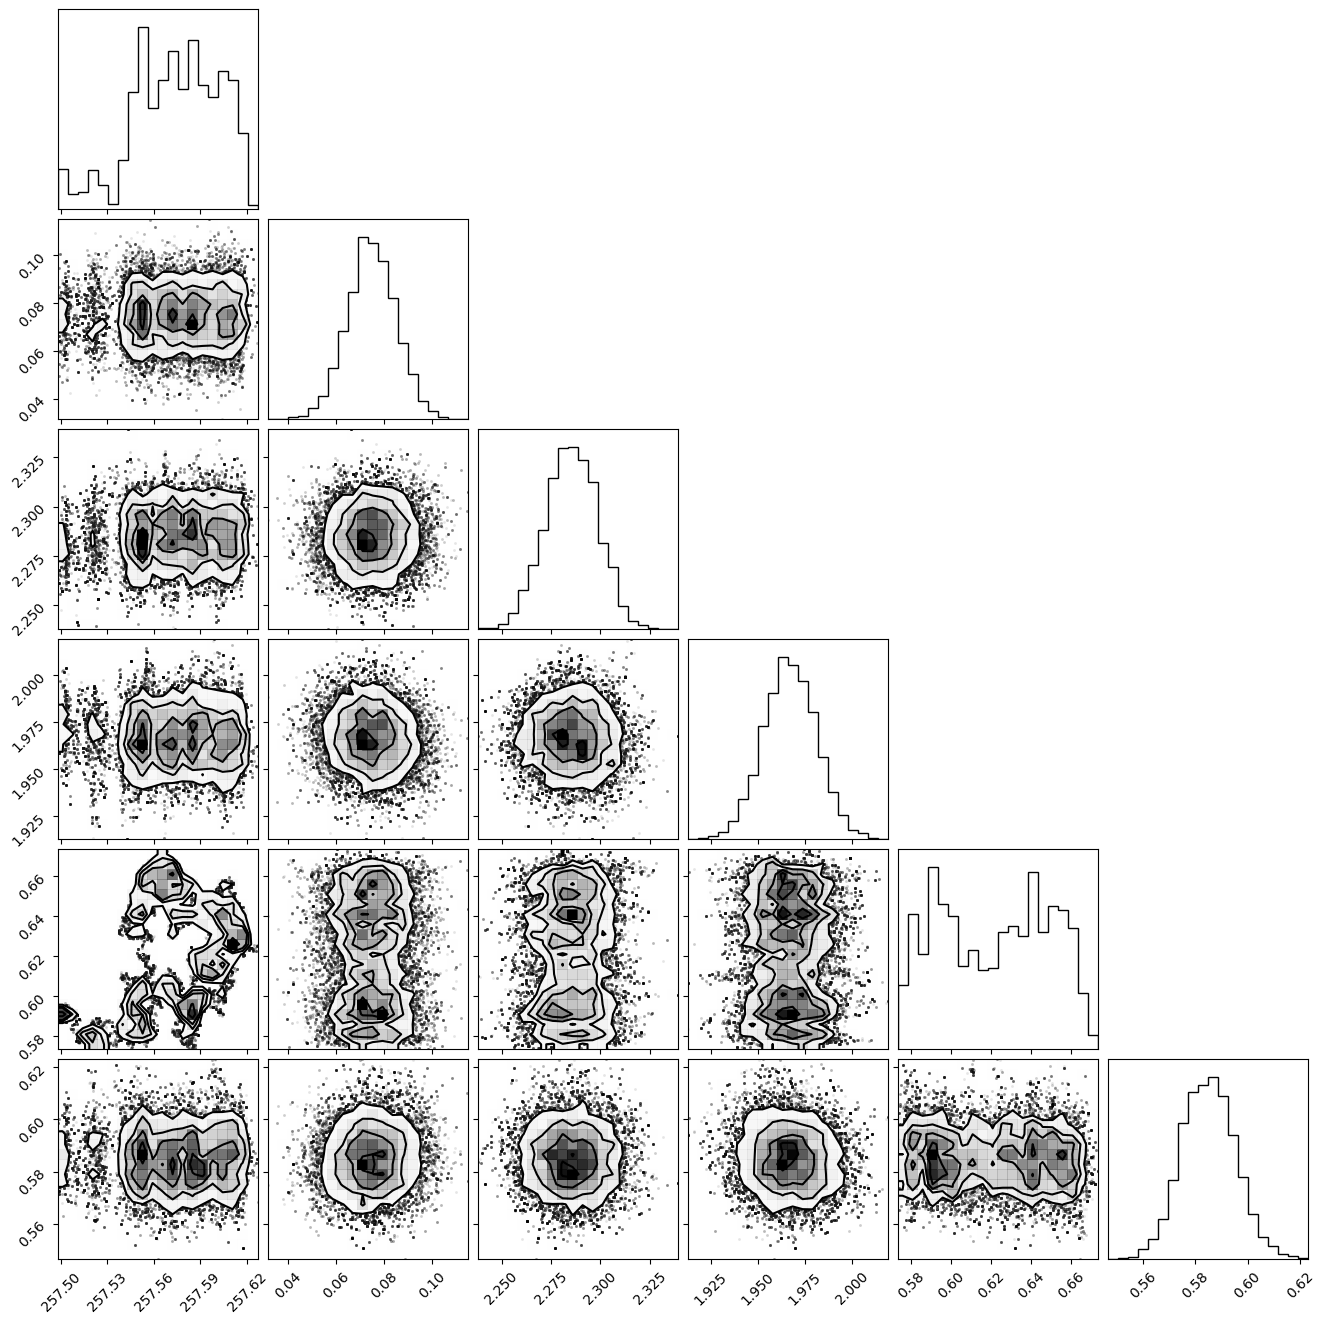

In [11]:
_ = corner(samples)

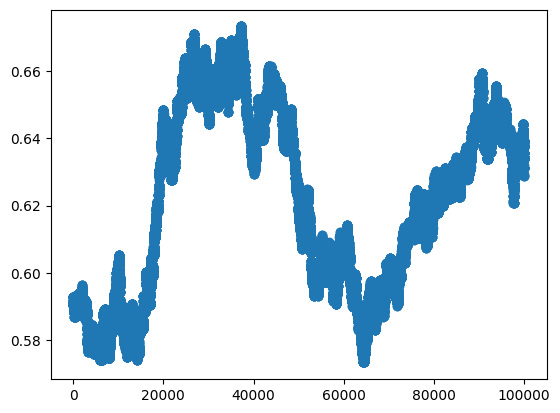

In [12]:
_ = plt.scatter(range(sample_array.shape[0]), sample_array[:,4])

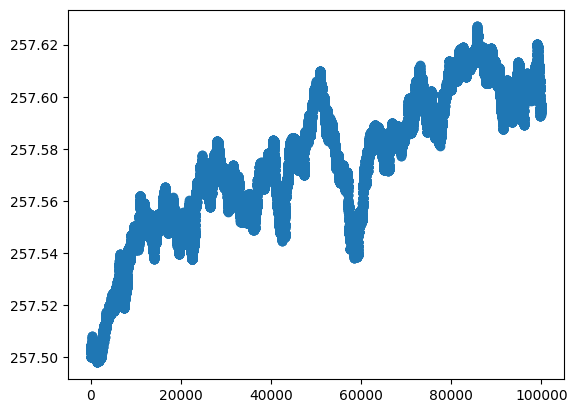

In [13]:
_ = plt.scatter(range(sample_array.shape[0]), sample_array[:,0])

In [14]:
sig = TwoSignal.with_period_param(100, np.mean(sample_array, axis=0), d11)

In [15]:
np.mean(samples, axis=0)
np.std(samples, axis=0)

array([2.57573823e+02, 7.46720438e-02, 2.28511928e+00, 1.96670418e+00,
       6.21412252e-01, 5.84914604e-01])

array([0.02776819, 0.0100894 , 0.01310482, 0.0141113 , 0.02697422,
       0.01029892])

In [16]:
ix = 4
conf(samples[:, ix]).reshape([2,1]) - np.mean(samples[:, ix])

array([[-0.04332382],
       [ 0.04259023]])

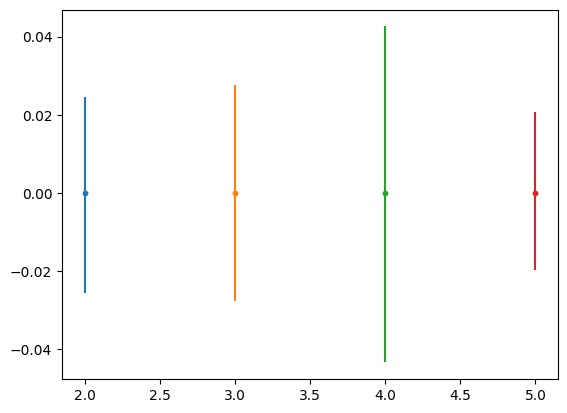

In [17]:
for ix in range(2, samples.shape[1]):
    s = samples[:,ix]
    _ = plt.errorbar(ix, 0, yerr=np.abs(conf(s).reshape([2,1])-np.mean(s)))
    _ = plt.scatter(ix, 0 ,s=10)

In [18]:
sig2.amplitude

(3.0162691873466714, 0.8288050755726364)

MCMC Average negloglike: 469.24722666557574 optimized negloglike: 469.33649346207613
Second Period: 257.57 ± 0.028 DC Level: 0.0747 ± 0.01 Amplitude 1: 3.01 ± 0.013 Amplitude 2: 0.853 ± 0.02


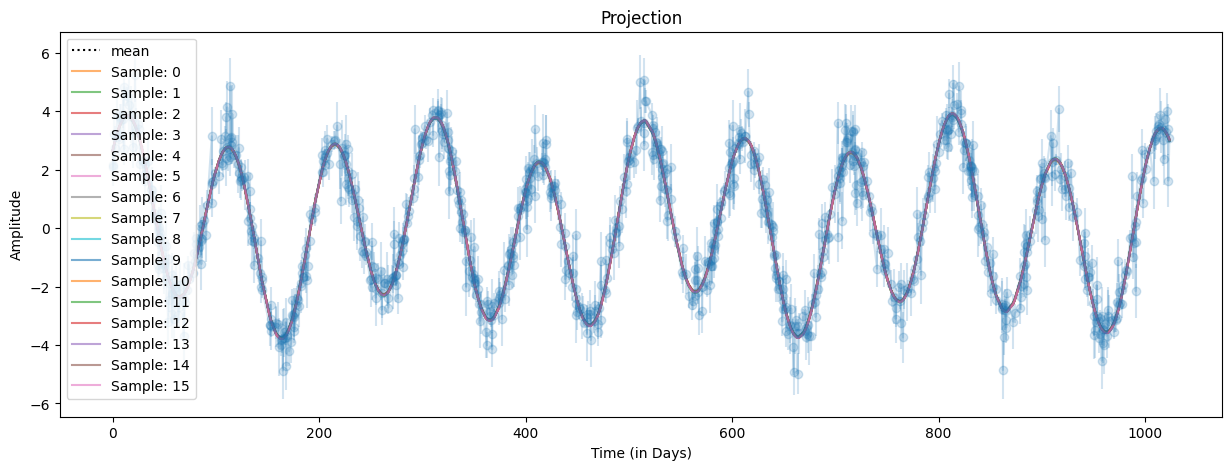

In [19]:
print(f"MCMC Average negloglike: {sig.negloglike()} optimized negloglike: {sig2.negloglike()}")

amp1_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,2:4], 2), axis=1)))
amp2_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,4:6], 2), axis=1)))

print(f"Second Period:{sig.T2: .5} \u00B1{np.std(samples[:,0]): .2}"
      ,f"DC Level:{sig.DC: .3} \u00B1{np.std(samples[:,1]): .2}"
      ,f"Amplitude 1:{sig.amplitude[0]: .3} \u00B1{amp1_std: .2}"
      ,f"Amplitude 2:{sig.amplitude[1]: .3} \u00B1{amp2_std: .2}")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ = ax.errorbar(d11.time, d11.data, yerr=d11.σy, marker="o", alpha=0.2)
_ = ax.plot(d11.time, sig.pred(d11.time), "k:", label="mean")

for ix, s in enumerate(np.random.choice(range(samples.shape[0]), size=16, replace=False)):
    _ = ax.plot(d11.time, TwoSignal(100, samples[s,0], np.array(samples[s,1:]), d11).pred(d11.time)
                , label=f"Sample: {ix}", alpha=0.6)

_ = ax.set_title("Projection")
_ = ax.set_xlabel("Time (in Days)")
_ = ax.set_ylabel("Amplitude")
_ = plt.legend()

The parameters given by the MCMC provide a nominally better fit than the parameters given by optimization! The estimated errors have gone down from their initial estimates: 
+ Second Period 0.21 -> 0.028
+ DC Level: 0.5 -> 0.01
+ Amplitude 1: 0.039 -> 0.013
+ Amplitude 2: 0.040 -> 0.028

Looking at the paramters that make up the second amplitude, it seems the cosine magnitude had to stay very constrained while the magnitude of the sine signal had much more freedom to move around the parameter space.

Taking 16 random samples from the MCMC run, all fit the data points very well.

### Problem 2

In [20]:
one_sig = Signal(100, [0.00569, 1, 1], d11)
one_sig.set_params(one_sig.analytic_params()[0])
_ = opt.minimize(one_sig.fit, one_sig.params)

In [21]:
prbm2_T2 = 257.47

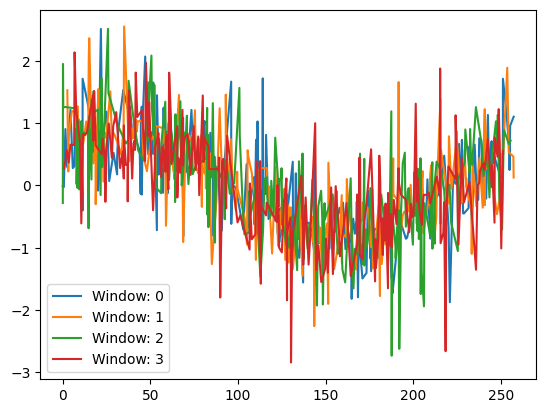

In [22]:
window = d11.time.apply(lambda x: x//prbm2_T2)
split_times = [d11.time.loc[window == i] for i in range(int(window.max())+1)]

for ix, ts in enumerate(split_times):  
    resid =  d11.loc[lambda x: x.time.isin(ts), 'data'] - one_sig.pred(ts)
    _ = plt.plot(ts-ix*prbm2_T2, resid, label=f"Window: {ix}")

_ = plt.legend()

From the above it seems like there is indeed a trend for the 257.47 day period. There seems to be a signal, remanisant of a cosine, at that time. It makes sense that the best fit model consideres a 2 period signal for this dataset

### Problem 3

In [23]:
with open(pth.join(data_path, 'data.pkl'), 'rb') as f:
    data = pkl.load(f)

df = pd.DataFrame(data, columns=["time","σy",*[f"data_set_{i}" for i in range(1,12)]])

In [24]:
def k_cross_fold(df, k, models, **kwargs):
    """
    Perform k-fold cross-validation
    
    Parameters
    ==========
    df: DataFrame
        Data set to be used in cross-validation
    k: int
        Number of folds to use. -1 or less for leave-one-out
    models: List[model]
        List of model classes to be compared in cross-validation
        
    Return
    ======
        List of accuracy measures and best fit models
    """
    o_params = np.zeros(3) if (ps:=kwargs.get('one_init_params')) is None else ps
    t_params = np.zeros(6) if (ps:=kwargs.get('two_init_params')) is None else ps
    kind = 'rand' if (cc:=kwargs.get('kind')) is None else cc
    
    # break data into folds
    folds = fold_data(df, k, kind=kind)
    if -1 == k:
        k = len(folds)
        
    mod_Δs = {'model_one': list(), 'model_two': list()}
    
    for m, p, Δ in zip(models, (o_params, t_params), ('model_one', 'model_two')):
        for ix in range(len(folds)): 
    # merge 7 train folds into one dataset. Make Test set
            train = pd.concat([folds[i] for i in range(k) if i !=ix])
            test = folds[ix]
    # fit model to train dataset
            mod = m(100, p, train)
            _ = mod.set_params(mod.analytic_params()[0])
            _ = opt.minimize(mod.fit, mod.params) 

    # predict 8th fold
            preds = mod.pred(test.time)
    
    # measure accuracy of fit and store it
            mod_Δs[Δ].append(np.sum(np.power((test.data - preds)/test.σy, 2)))
            lg.info("%s nll: %f",Δ, mod.negloglike())
    # return lists of accuracy measures 
    # and report which model was more acurate 
    # and by how much, assume single model in case of tie
    
    chk_1 = np.array(mod_Δs['model_one'])
    chk_2 = np.array(mod_Δs['model_two'])         
    
    return (np.sum(chk_1), np.sum(chk_2)), mod_Δs

def fold_data(df, k, kind='rand'):
    if kind == 'rand':
        ret = df.sample(frac=1)
        if k <= -1:
            return np.split(ret, ret.shape[0])
        return np.split(ret, k)

def aic(mod):
    _ = mod.set_params(mod.analytic_params()[0])
    _ = opt.minimize(mod.fit, mod.params) 
    return 2*(mod.params.size + mod.negloglike())

def bic(mod):
    _ = mod.set_params(mod.analytic_params()[0])
    _ = opt.minimize(mod.fit, mod.params) 
    return 2*(mod.params.size*np.log(mod.data.shape[0]) + mod.negloglike())

In [25]:
Snd_freqs = [0.15, 114, 201, 492, 546
            ,16, 138, 16, 328, 345, 257]

cv_res, aic_res, bic_res = (list(), list(), list())


for ds, freq in enumerate(Snd_freqs, start=1):
    d = df[['time','σy',f'data_set_{ds}']]
    d.columns = ['time', 'σy', 'data']
    two_init_params = [freq, *np.zeros(5)]
    
    cv_res.append(
        k_cross_fold(d, 8, [Signal, TwoSignal.with_period_param]
        , two_init_params = two_init_params
        , kind='rand')[0]
    )

    aic_res.append((
       aic(Signal(100, np.zeros(3), d))
      ,aic(TwoSignal.with_period_param(100, two_init_params, d))
    ))
    
    bic_res.append((
       bic(Signal(100, np.zeros(3), d))
      ,bic(TwoSignal.with_period_param(100, two_init_params, d))
    ))

    

In [26]:
comp_tbl = pd.concat(
    [pd.DataFrame(x
        ,columns=('Single', 'Double')
        ,index=pd.MultiIndex.from_tuples(
                    [(comp, f"ds_{j+1:0>2}") for j in range(len(x))]
               ,names=['Evaluation', 'Dataset'])) 
     for comp, x in zip(("cfv", "aic", "bic")
                     ,[cv_res, aic_res, bic_res])]
).unstack(0).stack(0)
comp_tbl.index.names = ['Dataset', 'Model']

In [27]:
color_pick = lambda x, c: f"background-color:{c}" if x > 0 else None

tst = comp_tbl.xs(key="Single", level='Model')\
    - comp_tbl.xs(key="Double", level='Model')
tst.style.applymap(color_pick, c='lightgreen')

Evaluation,aic,bic,cfv
Dataset,,,
ds_01,-3.801054,-27.526941,-2.918248
ds_02,3.123882,-20.602005,5.594309
ds_03,6.949844,-16.776043,9.955598
ds_04,5.237762,-18.488125,7.206692
ds_05,2.030410,-21.695478,4.127589
ds_06,6.452933,-17.272954,5.461979
ds_07,3014.290175,2990.564288,3079.558578
ds_08,4.594726,-19.131161,5.873045
ds_09,2240.131173,2216.405286,2313.301138


Considering all 3 criterion choosing the double-frequency model as the criterion for making the decision to use the double-frequency signal mostly aligns with the decisions made in the second problem set. The notable difference is dataset 8, in which the decision was made to use the double-frequency model.

Considering that the fit was rather strange to the data in that case, it may have been a case of over-fitting to the data, considering that the cross-validation is so low on it.